In [1]:
from src import parameter_spaces as ps
import time
import PIL

In [2]:
import numpy as np
from numba import njit, prange
from matplotlib import pyplot as plt

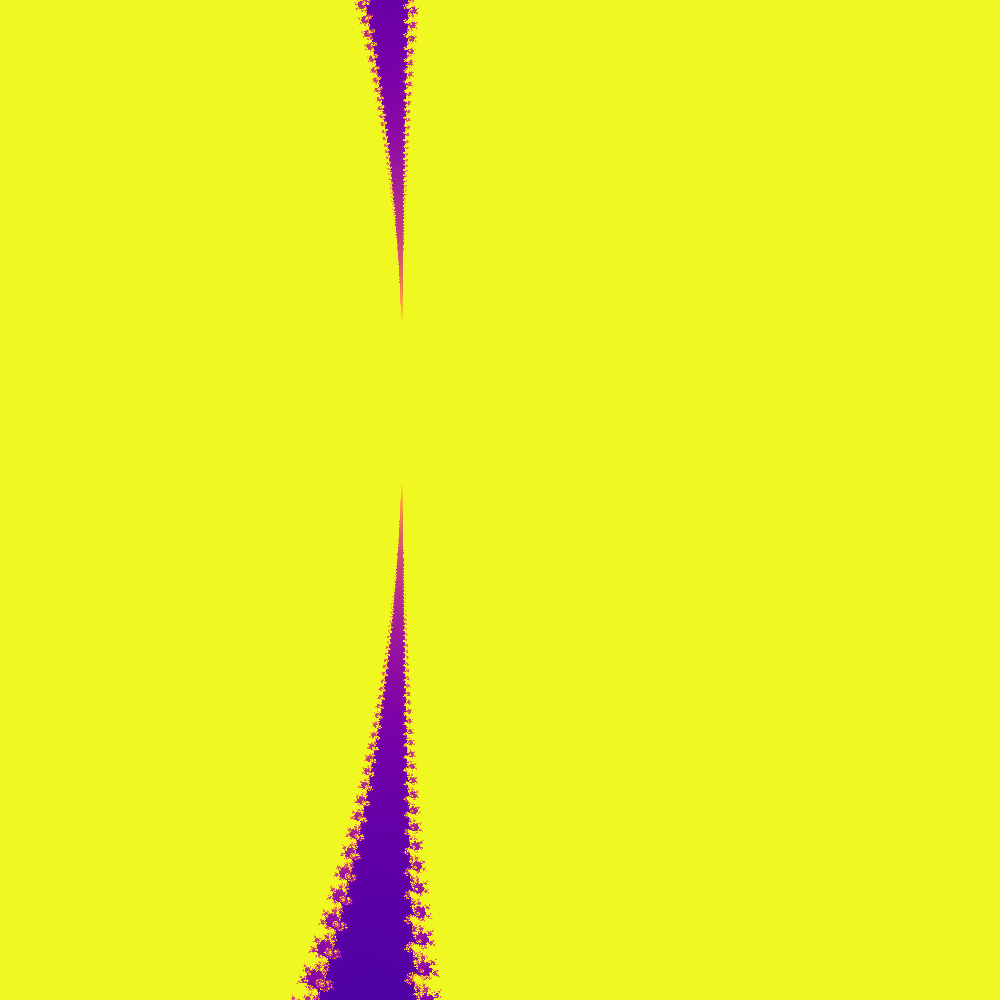


Dimension 1000x1000
Number of iterations 1000

Spent 0.1 seconds generating the complex plabe.
Spent 16.8 seconds generating Mandel points.
Spent 0.0 seconds generating image.
Spent 16.9 seconds in total.



In [6]:
x_dim = 1000
y_dim = 1000


max_iter = 1_000


# A window around the parabolic point -3/4.
x_min = -0.812
x_max = -0.658
y_min = -0.062j
y_max = 0.092j


start = time.perf_counter()

# This is the Complex plane
cplx_plane = np.zeros((y_dim,x_dim),dtype='complex128')# Create a x_dim by y_dim array of numbers 0.0+0.0j.
for l in range(y_dim):
    cplx_plane[l] = np.linspace(x_min,x_max,x_dim) - np.linspace(y_min,y_max,y_dim)[l] 
    #change the zeroes into the correct complex numbers based on the dimensions.
generated_cplx_plane = time.perf_counter()


# This computes the points in the Mandelbrot set
mandel = ps.mandelbrot(cplx_plane,x_dim,y_dim,max_iter) 
generated_mandel = time.perf_counter()


# This draws the Image
colors = plt.cm.plasma(mandel)*255
colors = np.array(colors, dtype=np.uint8)
new_image = PIL.Image.fromarray(colors)
generated_image = time.perf_counter()
new_image.show()


# Summarize execution time:
setup_time = round(generated_cplx_plane-start,3)
analysis_time = round(generated_mandel - generated_cplx_plane, 3)
image_generation_time = round(generated_image - generated_mandel, 3)
total_time = round(generated_image - start, 3)

print(f"""
Dimension {x_dim}x{y_dim}
Number of iterations {max_iter}

Spent {setup_time} seconds generating the complex plabe.
Spent {analysis_time} seconds generating Mandel points.
Spent {image_generation_time} seconds generating image.
Spent {total_time} seconds in total.
""")


#### ~17 seconds with 1_000 iterations
#### ~166 seconds with 10_000 iterations

In [84]:
class Disk:

    def __init__(self,center:complex,rad:float,word:str='',ref:complex=None):  
        self.center = center
        self.radius = rad
        self.word = word
        self.ref = 1.+0.j if (ref is None) else ref
  
    def is_disjoint(self,disk):
        return np.abs(self.center-disk.center) > (self.radius + disk.radius)
  
    def image_under(self,fcn:str, curr_c:complex):
        new_center = (self.center-self.ref) if (fcn == 'g') else (self.center+self.ref)
        new_rad = np.abs(curr_c) * self.radius
        new_ref = curr_c*self.ref
        new_word = self.word + fcn
        return Disk(new_center, new_rad, new_word, new_ref)
  
    def does_not_contain(self,pnt):
        return (np.abs(pnt-self.center) > self.radius)



def disconnected_general(curr_c:complex,depth:int):
    # adjusted from https://www.aldenwalker.org/schottky.html
    initial_ball = Disk(0.+0.j, 1/(1-np.abs(curr_c)));
    stack = np.array([[initial_ball.image_under('f',curr_c),
                       initial_ball.image_under('g',curr_c)]])
    steps = 0;
    while (len(stack) > 0 ) :
        b,stack = stack[-1], stack[:-1]
        
        if (b[0].is_disjoint(b[1])): continue

        if (len(b[0].word) == depth): return steps

        ff = b[0].image_under('f',curr_c)
        fg = b[0].image_under('g',curr_c)
        gf = b[1].image_under('f',curr_c)
        gg = b[1].image_under('g',curr_c)
        #there are 4 children: [ff,gg],[ff,gf],[fg,gg],[fg,gf],but
        #[fg,gg] and [ff,gf] have the same displacement, so forget [ff,gf]
        stack = np.append(stack,[[ff,gg]],axis=0)
        stack = np.append(stack,[[fg,gg]],axis=0)
        stack = np.append(stack,[[fg,gf]],axis=0)
        steps += 1 
    return 0;

def disconnected_at_zero(curr_c:complex,ball,depth:int): #TODO: avoid recursion
    if (ball.does_not_contain(0)): return False
    if (depth <= 0): return True
    ball_f = ball.image_under('f',curr_c)
    ball_g = ball.image_under('g',curr_c)
    return (disconnected_at_zero(curr_c, ball_f, depth-1) or disconnected_at_zero(curr_c, ball_g, depth-1))

def barnsley_set(c, x_dim = 500, y_dim = 500, depth = 10):
    cntr = np.empty_like(c, dtype=np.int64) #create a counter for each point in the plane
                                            #it will tell whether the parameter is in the Barnsley set
    
    for y in range(y_dim):
        for x in range(x_dim):
            cntr[y][x]=disconnected_general(c[y][x],depth)
    return cntr

def thurston_set(c, x_dim = 500, y_dim = 500, depth = 10): #TODO: implement more like barnsley_set
    cntr = np.empty_like(c, dtype=np.int64) #create a counter for each point in the plane
                                            #it will tell whether the parameter is in the Thurston set
    
    for y in range(y_dim):
        for x in range(x_dim):
            initial_ball = Disk(1.+0.j, np.abs(c[y][x])/(1-np.abs(c[y][x])),'f',c[y][x])
            cntr[y][x] = depth if (disconnected_at_zero(c[y][x],initial_ball,depth)) else 0
    return cntr

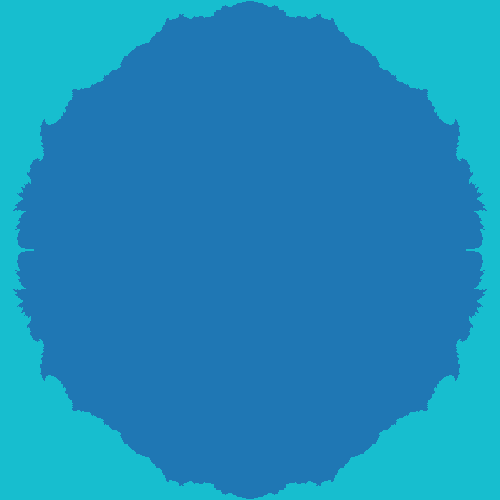


Dimension 500x500
Depth 15

Spent 0.018 seconds generating the complex plabe.
Spent 86.359 seconds generating Barnsley points.
Spent 0.019 seconds generating image.
Spent 86.396 seconds in total.



In [112]:
x_dim = 500
y_dim = 500


depth = 15


#The window.
x_min = -0.707
x_max = 0.707
y_min = -0.707j
y_max = 0.707j


start = time.perf_counter()

# This is the Complex plane
cplx_plane = np.zeros((y_dim,x_dim),dtype='complex128')# Create a x_dim by y_dim array of numbers 0.0+0.0j.
for l in range(y_dim):
    cplx_plane[l] = np.linspace(x_min,x_max,x_dim) + np.linspace(y_min,y_max,y_dim)[l] 
    #change the zeroes into the correct complex numbers based on the dimensions.

generated_cplx_plane = time.perf_counter()

barnsley = barnsley_set(cplx_plane,x_dim,y_dim,depth)
generated_barnsley = time.perf_counter()



# This draws the Image
colors = plt.cm.tab10(barnsley)*255
colors = np.array(colors, dtype=np.uint8)
new_img = PIL.Image.fromarray(colors)
new_img = new_img.transpose(PIL.Image.Transpose.FLIP_TOP_BOTTOM)
new_img.show()
generated_image = time.perf_counter()


# Summarize execution time:
setup_time = round(generated_cplx_plane-start,3)
analysis_time = round(generated_barnsley - generated_cplx_plane, 3)
image_generation_time = round(generated_image - generated_barnsley, 3)
total_time = round(generated_image - start, 3)


print(f"""
Dimension {x_dim}x{y_dim}
Depth {depth}

Spent {setup_time} seconds generating the complex plabe.
Spent {analysis_time} seconds generating Barnsley points.
Spent {image_generation_time} seconds generating image.
Spent {total_time} seconds in total.
""")